# Image Generation using Autoencoder: MNIST
- **Images**: Handwritten digits **(28x28, grayscale)**.
- **Classes**: 10 digit classes (0-9), but for Autoencoder we **ignore labels**.
- **Shape**: `(batch_size, 1, 28, 28)` → 1 grayscale channel.
  
![MNIST image](https://i.imgur.com/TQlKspY.png)


## 1️⃣ Dataset Class

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits

# Define transformations (convert to tensor)
transform = transforms.Compose([transforms.ToTensor(),  # Convert to tensor
])

# Load MNIST dataset
train_dataset = MNIST(root="./datasets", train=True, transform=transform, download=True)
test_dataset = MNIST(root="./datasets", train=False, transform=transform, download=True)

# Create DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check dataset size
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 60000
Test samples: 10000


### Let's display some images

In [16]:
batch = next(iter(train_loader))[0]
batch

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

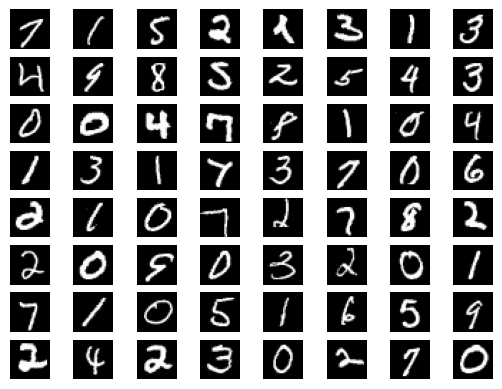

In [17]:
import matplotlib.pyplot as plt
for i in range(batch.shape[0]):
  plt.subplot(8,8,i+1)
  plt.imshow(batch[i,0,:,:], cmap = "gray")
  plt.axis("off")

## 2️⃣ Model Class

# **📌 Autoencoder Model**
An **Autoencoder** is a type of neural network that learns to **compress (encode) and reconstruct (decode) input data**.

## **🔹 Model Structure**
1️⃣ **Encoder**
   - **Conv2D Layers** → Extract important features.
   - **Fully Connected Layer** → Reduce to a compressed **encoding vector**.
   - Output: **Low-dimensional representation** of the input.

2️⃣ **Decoder**
   - **Fully Connected Layer** → Expands compressed representation.
   - **Transpose Convolution Layers** → Reconstructs the input.
   - Output: **Reconstructed image** (same shape as input).

![image.png](https://i.imgur.com/SzuIOLi.png)
---
## **📌 Expected Input & Output Shapes**
- **Input:** `(batch_size, 1, 28, 28)`  
- **Encoded Representation:** `(batch_size, encoding_dim)`  
- **Decoded Output:** `(batch_size, 1, 28, 28)`

In [18]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, encoding_dim = 128):
        super(Autoencoder, self).__init__()

        # --- Encoder ---
        # Input: (batch_size, 1, 28, 28)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # -> (batch_size, 16, 14, 14)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (batch_size, 32, 7, 7)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Flatten(),                                         # -> (batch_size, 32 * 7 * 7) = 1568
            nn.Linear(32 * 7 * 7, encoding_dim),                   # -> (batch_size, encoding_dim)
            nn.BatchNorm1d(encoding_dim),
            nn.Tanh(),
            # 当你的输入图像像素被归一化到 [0, 1] 范围时（这是 MNIST 数据集常用做法，通过 transforms.ToTensor() 实现），模型的中间特征值可能会变得任意大或小。
            # 使用 Tanh 激活函数可以将输出限制在 [-1, 1] 范围内，这有助于稳定训练过程。
            # 这对于自编码器来说是有益的，因为它可以防止梯度爆炸或消失问题，尤其是在深层网络中。
            # 这也有助于在解码器中使用 Sigmoid 激活函数
            # 因为 Sigmoid 的输出范围是 [0, 1]，而 Tanh 的输出范围是 [-1, 1]，所以在编码器和解码器之间使用 Tanh 可以更好地适应 Sigmoid 的输出范围。

        )

        # --- Decoder ---
        # Input: (batch_size, encoding_dim)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 7 * 7),                  # -> (batch_size, 1568)
            nn.BatchNorm1d(32 * 7 * 7),
            nn.LeakyReLU(),
            nn.Unflatten(1, (32, 7, 7)),                          # -> (batch_size, 32, 7, 7)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (batch_size, 16, 14, 14)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (batch_size, 1, 28, 28)
            nn.Sigmoid()                                          # -> Output values between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## 3️⃣ Training and Validation Loops

We will train a model and show images instantly without a validation loop.

1️⃣ **Forward Pass** → Encode & Decode the image.  
2️⃣ **Compute Loss** → Measure the difference between input & reconstructed output.  
3️⃣ **Backward Pass** → Adjust model parameters using backpropagation.  


## 4️⃣ Running Training

Unlike classification, Autoencoders use **MSE Loss** to compare the reconstructed image with the input.


In [10]:
from tqdm import tqdm    # Shows progress bar
import torch.backends.mps  # For Apple Silicon GPU support

# Check if MPS (Metal Performance Shaders) is available for Apple Silicon GPU acceleration
# MPS is a framework that allows PyTorch to utilize the GPU on Apple Silicon devices.
# If MPS is not available, we will fall back to CPU.
# This is particularly useful for users with MacBooks or Macs with M1/M2 chips.
# Note: MPS support is available in PyTorch 1.12 and later versions.
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")

# Model Initialization
encoding_dim = 16
model = Autoencoder(encoding_dim=encoding_dim).to(device)

# Print model structure
print("Model structure:")
print(model)

# Loss function
criterion = nn.MSELoss()

# Optimizer
# We use the Adam optimizer, a popular and effective choice for many problems.
# It adjusts the learning rate for each parameter.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # lr = learning rate

# Training Loop
num_epochs = 50 # Increase from 10
patience = 5    # Increase patience slightly for longer training

outputs = []
losses = []

print("🚀 Starting training...")

for epoch in range(num_epochs):
    # 1. 在每个 epoch 开始时，初始化一个累加器
    running_loss = 0.0

    # 遍历所有批次
    for images, _ in tqdm(train_loader):
        images = images.to(device)
        reconstructed = model(images)
        loss = criterion(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 2. 累加每个批次的损失值
        # loss.item() 是当前批次的平均损失
        running_loss += loss.item()

    # 3. 在 epoch 结束后，计算整个 epoch 的平均损失
    epoch_loss = running_loss / len(train_loader) # 总损失除以总批次数

    # 4. 打印平均损失
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')
    losses.append(epoch_loss) # 保存平均损失以便后续绘图

    # (可选) 仍然可以保存最后一个批次的图像用于可视化
    outputs.append((epoch, images.cpu(), reconstructed.cpu()))

print("🎉 Training finished! 🎉")

Using MPS device for Apple Silicon GPU acceleration.
Model structure:
Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=16, bias=True)
    (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=1568, bias=True)
    (1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Unflatten(dim=1, unflattened_size=(32, 7, 7))

100%|██████████| 938/938 [00:10<00:00, 87.38it/s] 


Epoch [1/50], Average Loss: 0.0400


100%|██████████| 938/938 [00:08<00:00, 114.82it/s]


Epoch [2/50], Average Loss: 0.0164


100%|██████████| 938/938 [00:07<00:00, 118.05it/s]


Epoch [3/50], Average Loss: 0.0146


100%|██████████| 938/938 [00:08<00:00, 106.88it/s]


Epoch [4/50], Average Loss: 0.0138


100%|██████████| 938/938 [00:07<00:00, 122.06it/s]


Epoch [5/50], Average Loss: 0.0132


100%|██████████| 938/938 [00:08<00:00, 115.35it/s]


Epoch [6/50], Average Loss: 0.0129


100%|██████████| 938/938 [00:08<00:00, 110.13it/s]


Epoch [7/50], Average Loss: 0.0126


100%|██████████| 938/938 [00:08<00:00, 106.78it/s]


Epoch [8/50], Average Loss: 0.0124


100%|██████████| 938/938 [00:08<00:00, 114.17it/s]


Epoch [9/50], Average Loss: 0.0123


100%|██████████| 938/938 [00:08<00:00, 106.76it/s]


Epoch [10/50], Average Loss: 0.0121


100%|██████████| 938/938 [00:08<00:00, 111.69it/s]


Epoch [11/50], Average Loss: 0.0120


100%|██████████| 938/938 [00:08<00:00, 114.82it/s]


Epoch [12/50], Average Loss: 0.0119


100%|██████████| 938/938 [00:08<00:00, 115.29it/s]


Epoch [13/50], Average Loss: 0.0119


100%|██████████| 938/938 [00:08<00:00, 116.86it/s]


Epoch [14/50], Average Loss: 0.0118


100%|██████████| 938/938 [00:07<00:00, 118.85it/s]


Epoch [15/50], Average Loss: 0.0117


100%|██████████| 938/938 [00:08<00:00, 116.41it/s]


Epoch [16/50], Average Loss: 0.0117


100%|██████████| 938/938 [00:07<00:00, 118.91it/s]


Epoch [17/50], Average Loss: 0.0116


100%|██████████| 938/938 [00:07<00:00, 117.56it/s]


Epoch [18/50], Average Loss: 0.0115


100%|██████████| 938/938 [00:07<00:00, 121.89it/s]


Epoch [19/50], Average Loss: 0.0115


100%|██████████| 938/938 [00:08<00:00, 114.84it/s]


Epoch [20/50], Average Loss: 0.0115


100%|██████████| 938/938 [00:08<00:00, 106.02it/s]


Epoch [21/50], Average Loss: 0.0114


100%|██████████| 938/938 [00:07<00:00, 119.13it/s]


Epoch [22/50], Average Loss: 0.0114


100%|██████████| 938/938 [00:07<00:00, 121.53it/s]


Epoch [23/50], Average Loss: 0.0114


100%|██████████| 938/938 [00:07<00:00, 117.86it/s]


Epoch [24/50], Average Loss: 0.0113


100%|██████████| 938/938 [00:07<00:00, 127.31it/s]


Epoch [25/50], Average Loss: 0.0113


100%|██████████| 938/938 [00:07<00:00, 125.34it/s]


Epoch [26/50], Average Loss: 0.0113


100%|██████████| 938/938 [00:07<00:00, 122.02it/s]


Epoch [27/50], Average Loss: 0.0112


100%|██████████| 938/938 [00:07<00:00, 118.92it/s]


Epoch [28/50], Average Loss: 0.0112


100%|██████████| 938/938 [00:07<00:00, 118.52it/s]


Epoch [29/50], Average Loss: 0.0112


100%|██████████| 938/938 [00:09<00:00, 102.07it/s]


Epoch [30/50], Average Loss: 0.0112


100%|██████████| 938/938 [00:08<00:00, 107.05it/s]


Epoch [31/50], Average Loss: 0.0111


100%|██████████| 938/938 [00:08<00:00, 108.89it/s]


Epoch [32/50], Average Loss: 0.0111


100%|██████████| 938/938 [00:08<00:00, 111.40it/s]


Epoch [33/50], Average Loss: 0.0111


100%|██████████| 938/938 [00:08<00:00, 109.35it/s]


Epoch [34/50], Average Loss: 0.0110


100%|██████████| 938/938 [00:08<00:00, 113.37it/s]


Epoch [35/50], Average Loss: 0.0110


100%|██████████| 938/938 [00:08<00:00, 110.38it/s]


Epoch [36/50], Average Loss: 0.0110


100%|██████████| 938/938 [00:08<00:00, 111.99it/s]


Epoch [37/50], Average Loss: 0.0110


100%|██████████| 938/938 [00:08<00:00, 115.69it/s]


Epoch [38/50], Average Loss: 0.0110


100%|██████████| 938/938 [00:08<00:00, 105.61it/s]


Epoch [39/50], Average Loss: 0.0109


100%|██████████| 938/938 [00:08<00:00, 113.19it/s]


Epoch [40/50], Average Loss: 0.0109


100%|██████████| 938/938 [00:08<00:00, 111.15it/s]


Epoch [41/50], Average Loss: 0.0109


100%|██████████| 938/938 [00:08<00:00, 114.02it/s]


Epoch [42/50], Average Loss: 0.0109


100%|██████████| 938/938 [00:08<00:00, 114.80it/s]


Epoch [43/50], Average Loss: 0.0109


100%|██████████| 938/938 [00:08<00:00, 108.62it/s]


Epoch [44/50], Average Loss: 0.0108


100%|██████████| 938/938 [00:08<00:00, 110.84it/s]


Epoch [45/50], Average Loss: 0.0108


100%|██████████| 938/938 [00:08<00:00, 106.84it/s]


Epoch [46/50], Average Loss: 0.0109


100%|██████████| 938/938 [00:07<00:00, 121.30it/s]


Epoch [47/50], Average Loss: 0.0108


100%|██████████| 938/938 [00:07<00:00, 127.11it/s]


Epoch [48/50], Average Loss: 0.0108


100%|██████████| 938/938 [00:07<00:00, 128.89it/s]


Epoch [49/50], Average Loss: 0.0108


100%|██████████| 938/938 [00:07<00:00, 128.57it/s]

Epoch [50/50], Average Loss: 0.0108
🎉 Training finished! 🎉


### Plot loss and some predictions

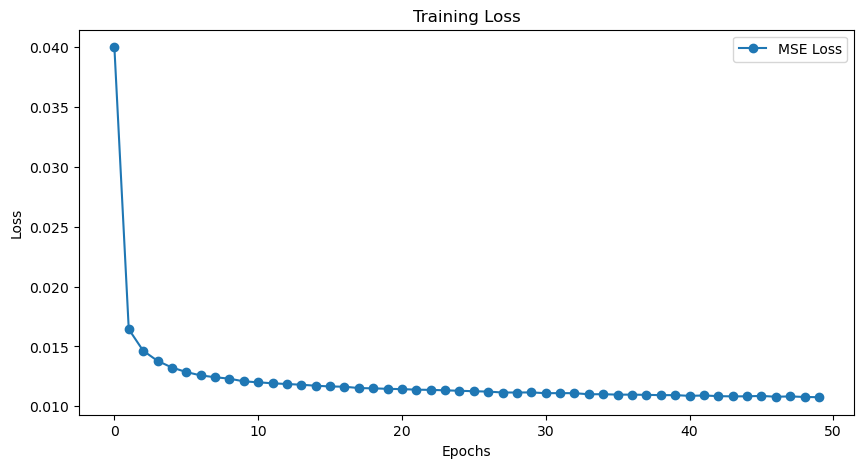

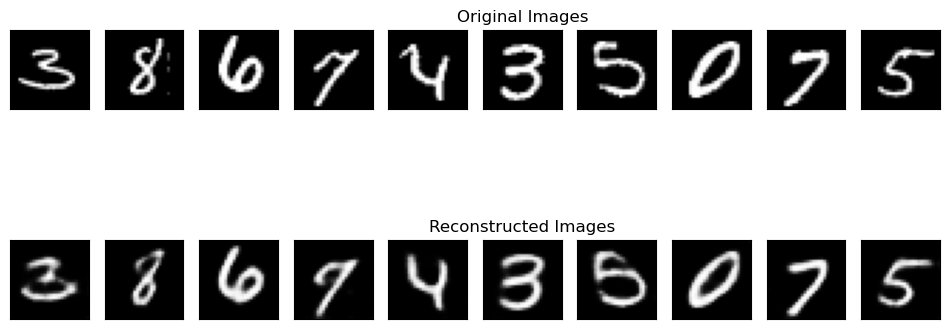

In [19]:
# Plot the loss
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(losses,label="MSE Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualize the last batch of original and reconstructed images
original_images = outputs[-1][1].detach().numpy()
reconstructed_images = outputs[-1][2].detach().numpy()

# Number of images to display
n = 10

plt.figure(figsize=(12, 5))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n // 2:
        ax.set_title("Original Images")


    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n // 2:
        ax.set_title("Reconstructed Images")
plt.show()

Let's generate some images:

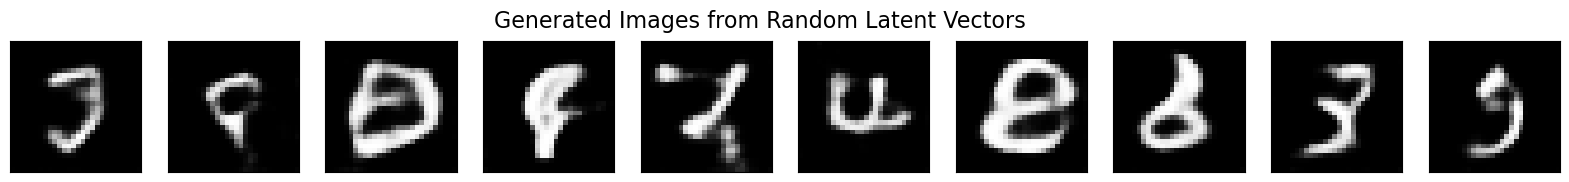

In [12]:
# Generate images by feeding random vectors to the decoder
num_generated_images = 10

with torch.no_grad(): # We don't need to compute gradients for this
    # Create random latent vectors
    random_vectors = torch.randn(num_generated_images, encoding_dim).to(device)

    # Decode them to create new images
    generated_images = model.decoder(random_vectors).cpu()

# Display the generated images
plt.figure(figsize=(20, 2))
for i in range(num_generated_images):
    ax = plt.subplot(1, num_generated_images, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.suptitle("Generated Images from Random Latent Vectors", fontsize=16)
plt.show()

Close Enough :)

In [14]:
encoder_model = model.encoder
encoder_model.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=16, bias=True)
  (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Tanh()
)

In [20]:
import numpy as np

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for Apple Silicon GPU acceleration.")
else:
    device = torch.device("cpu")
    print("MPS device not found, falling back to CPU.")

encoder_model.to(device)

latent_vectors_list = []
true_labels_list = []

# 对测试集进行迭代，获取所有潜在向量和对应的标签
with torch.no_grad(): # 在推理时不需要计算梯度
    for images, labels in test_dataloader:
        images = images.to(device)
        # 如果你的编码器期望展平的输入，请在这里展平
        # 例如：images = images.view(images.size(0), -1)

        latent = encoder_model(images)
        latent_vectors_list.append(latent.cpu().numpy())
        true_labels_list.append(labels.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors_list, axis=0)
true_labels = np.concatenate(true_labels_list, axis=0)

print(f"潜在向量的形状: {latent_vectors.shape}")
print(f"标签的形状: {true_labels.shape}")

Using MPS device for Apple Silicon GPU acceleration.
潜在向量的形状: (10000, 16)
标签的形状: (10000,)


开始t-SNE降维...
t-SNE降维完成。
降维后的形状: (10000, 2)


/var/folders/rh/2t3sy5bx13nctf2n07gkzskh0000gn/T/ipykernel_52841/2441294119.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels)) # 使用tab10颜色映射


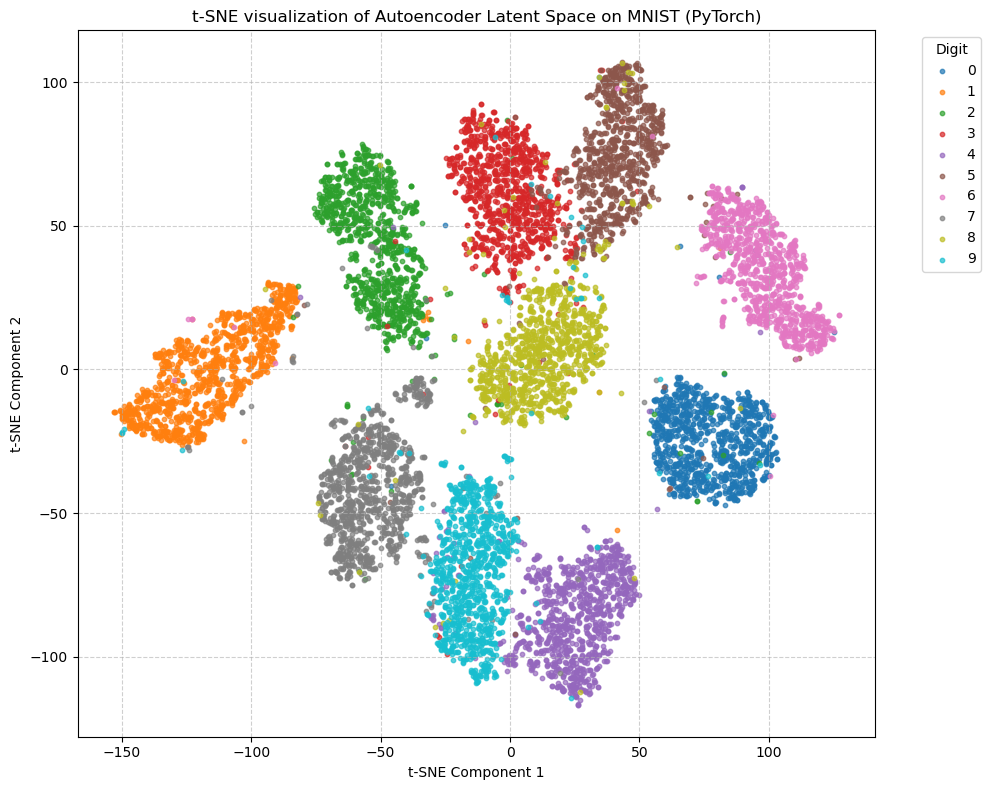

In [ ]:
print("开始t-SNE降维...")
# 减少数据量以加快t-SNE，或者使用完整数据集如果内存允许且计算时间可接受
# num_samples_for_tsne = 5000
# if latent_vectors.shape[0] > num_samples_for_tsne:
#     # 随机选择一部分样本
#     indices = np.random.choice(latent_vectors.shape[0], num_samples_for_tsne, replace=False)
#     tsne_latent_vectors = latent_vectors[indices]
#     tsne_true_labels = true_labels[indices]
# else:
tsne_latent_vectors = latent_vectors
tsne_true_labels = true_labels

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=3000)
latent_2d = tsne.fit_transform(tsne_latent_vectors)
print("t-SNE降维完成。")
print(f"降维后的形状: {latent_2d.shape}")

# 可视化结果
plt.figure(figsize=(10, 8))

unique_labels = np.unique(tsne_true_labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels)) # 使用tab10颜色映射

for i, label in enumerate(unique_labels):
    indices = tsne_true_labels == label
    plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1],
                color=colors(i),
                label=str(label),
                alpha=0.7,
                s=10)

plt.title('t-SNE visualization of Autoencoder Latent Space on MNIST (PyTorch)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **🔹 Exercise: Effect of Encoding Dimension on Reconstruction**
The **encoding dimension** controls how much information is compressed in the latent space.

### **📝 Task**
- Try running the model with **different `encoding_dim` values** (e.g., `1, 2, 128, 256`).
- Observe how the quality of the **reconstructed images** changes.

### Our Solution:

When we changerd the `encoding_dim` to 128, we can see that the model is able to reconstruct the images with a lower loss compared to when it was set to 16. This indicates that a higher dimensional latent space allows the model to capture more information about the input images, leading to better reconstructions.

### Contributed by: Mohamed Eltayeb

## New discovery about the importance of batch's normalizing

在第一次中，我对于batch没有进行normalize的操作，最后得到的loss还算比较好，但是由于我其实进行了50个epoch，所以其实这是模型训练costy的功劳（苦劳）。

但是问题在于，**生成的图片是一坨💩！**
非常的混沌，很难看出是什么数字，而最重要的问题在于非常黑不溜秋，白的部分非常少。

在增加了新的batch  normalize之后，模型的效果大大提升了，最主要提升的是：我们可以看出来白色的部分了，以及可以看出一些些数字的模样，虽然和我们现实生活中的数字不是很相像，但是其实是我们的模型探索出来的对于“人类的数字应该长什么样”的一种抽象观察与直觉。

**batch  normalizing的好处：**

* 加速训练收敛： 批量归一化有助于缓解“内部协变量偏移”问题，即使得每一层的输入分布保持稳定。这允许模型使用更高的学习率，从而更快地收敛。

* 提高训练稳定性： 通过将激活值归一化，它可以防止激活值在网络深层变得过大或过小，从而缓解梯度消失或梯度爆炸问题，使得训练过程更加稳定。

* 正则化效果： 批量归一化在每个小批次上引入的均值和方差估计的噪声，类似于 Dropout，可以起到轻微的正则化作用，减少模型对训练数据的过拟合，提高泛化能力。

* 对初始化不那么敏感： 模型对权重初始化的选择不再那么敏感。

总之，**批量归一化层**：大大增强了训练的**稳定性**和**收敛速度**，并提供了额外的正则化效果

In [18]:
### 一个典型的深度学习代码框架：

# 初始化模型、损失函数和优化器
model = Autoencoder(...)
criterion = nn.MSELoss() # 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam 优化器

# 训练循环 (for each epoch)
for epoch in range(num_epochs):
    # 遍历每个批次 (for each batch)
    for batch_idx, data in enumerate(dataloader):
        # 0. 清除之前的梯度 (重要步骤，防止梯度累积)
        optimizer.zero_grad() # Adam 优化器的一个方法

        # 1. Forward Pass (前向传播)
        reconstructed_output = model(data) # 编码和解码图像

        # 2. Compute Loss (计算损失)
        loss = criterion(reconstructed_output, data) # 测量输入与重建输出的差异

        # 3. Backward Pass (反向传播)
        loss.backward() # 计算损失对模型参数的梯度

        # 4. Optimizer Step (优化器更新参数)
        optimizer.step() # Adam 优化器根据计算出的梯度调整模型参数
                          # 这是 Adam 具体算法逻辑发挥作用的地方
                          # 它会考虑梯度的历史信息（动量和自适应学习率）来更新参数